In [1]:
# import libraries
import os
import re
import pandas as pd  # for storing text and embeddings data
import matplotlib.pyplot as plt
from openai import OpenAI  # for calling the OpenAI API
from openai.types.chat import ChatCompletionMessageParam
import tiktoken  # for counting tokens
from utils.embeddings_utils import cosine_similarity, get_embedding


# EMBEDDING_MODEL = "text-embedding-3-small"
# 3-small is broken, so we use ada-002 instead
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [2]:
OUTPUT_PATH = "processed/embeddings/case.csv"

directory = os.path.dirname(OUTPUT_PATH)
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
def parse_directory(base_dir):
    data = []
    pattern = re.compile(r"[a-zA-Z0-9]+_[a-zA-Z0-9\-]+$")

    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            if not pattern.match(dir_name):
                continue  # Skip directories not matching the pattern. e.g. ___prebuilt-tx
            dir_path = os.path.join(root, dir_name)
            network, case = dir_name.split("_")
            index_ts_path = os.path.join(dir_path, "index.ts")
            index_details_ts_path = os.path.join(dir_path, "index.details.ts")

            index_data = ""
            details_data = ""

            if os.path.exists(index_ts_path):
                with open(index_ts_path, "r") as index_file:
                    index_data = index_file.read().strip()

            if os.path.exists(index_details_ts_path):
                with open(index_details_ts_path, "r") as details_file:
                    details_data = details_file.read().strip()

            data.append(
                {
                    "case": case.replace("-", "_"),
                    "text": f"{case}. {network}. {index_data}. {details_data}",
                }
            )
    return data


data = parse_directory("case/")
df = pd.DataFrame(data)
df.to_csv(OUTPUT_PATH)
print(f"Data shape: {df.shape}")

Data shape: (44, 2)


In [4]:
def remove_newlines(serie):
    """
    Remove newlines from a pandas series for better processing.
    """
    serie = serie.str.replace("\n", " ")
    serie = serie.str.replace("\\n", " ")
    serie = serie.str.replace("  ", " ")
    serie = serie.str.replace("  ", " ")
    return serie


df["text"] = remove_newlines(df["text"])  # remove newlines for better embeddings
df.to_csv(OUTPUT_PATH)
df.head()

,case,text
0,multi_sender,multi-sender. polygon. import type { Abi } fro...
1,zircuit_eigenpie_swell,zircuit-eigenpie-swell. ethereum. import type ...
2,genesis_liquidity,genesis-liquidity. ethereum. import type { Abi...
3,yearn_v3_usdt,"yearn-v3-usdt. polygon. import type { Abi, Add..."
4,pendle_points,"pendle-points. arbitrum. import { BatchCase, C..."


# Show histogram of the tokens in the text


Text(0.5, 1.0, 'Histogram of Number of Tokens')

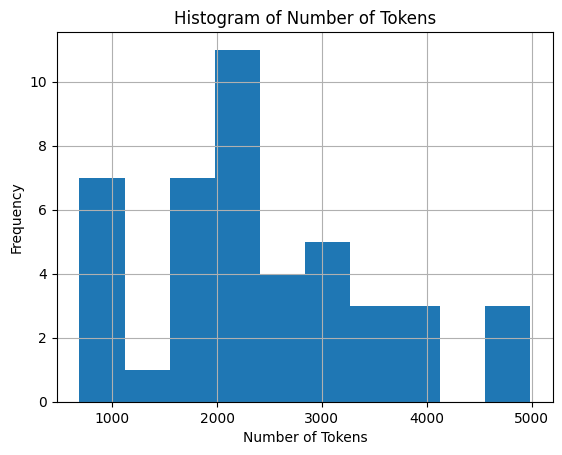

In [5]:
# Initialize the tokenizer
encoding_name = tiktoken.encoding_name_for_model(EMBEDDING_MODEL)
tokenizer = tiktoken.get_encoding(encoding_name)

df = pd.read_csv(OUTPUT_PATH, index_col=0)
df.columns = ["case", "text"]

# Tokenize the text and save the number of tokens to a new column
df["n_tokens"] = df["text"].apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Tokens")

# Create embeddings


In [6]:
df["text_embedding"] = df["text"].apply(
    lambda x: get_embedding(text=x, model=EMBEDDING_MODEL)
)

df.to_csv(OUTPUT_PATH)
df.head()

,case,text,n_tokens,text_embedding
0,multi_sender,multi-sender. polygon. import type { Abi } fro...,1889,"[0.004503462463617325, 0.00693918764591217, -0..."
1,zircuit_eigenpie_swell,zircuit-eigenpie-swell. ethereum. import type ...,3583,"[0.01974830962717533, 0.0014942557318136096, 0..."
2,genesis_liquidity,genesis-liquidity. ethereum. import type { Abi...,4817,"[0.01786457933485508, 0.013659048825502396, -0..."
3,yearn_v3_usdt,"yearn-v3-usdt. polygon. import type { Abi, Add...",2234,"[-0.003186991438269615, -0.0048324489034712315..."
4,pendle_points,"pendle-points. arbitrum. import { BatchCase, C...",2372,"[0.02143111638724804, 0.01149719674140215, -0...."


# Find relevant embeddings


In [7]:
def search(df, query, top_n=5):
    query_embedding = get_embedding(text=query, model=EMBEDDING_MODEL)

    def calculate_similarity(row):
        return (
            cosine_similarity(query_embedding, row["text_embedding"]),
            row["case"],
            row["text"],
        )

    case_to_score_list = [calculate_similarity(row) for _, row in df.iterrows()]
    case_to_score_list.sort(key=lambda x: x[0], reverse=True)
    top_cases = case_to_score_list[:top_n]
    return top_cases


def print_search_results_pretty(result):
    for score, case, text in result:
        print(f"Score: {score.round(4)}")
        print(f"Case: {case}")
        print(f"Code: {text[:100]}...")
        print("-" * 70)  # separator

# Examples


In [8]:
result = search(df, "Deposit USDT to Yearn finance's V3 Vault.", top_n=3)
print_search_results_pretty(result)

Score: 0.8248
Case: yearn_v3_usdt
Code: yearn-v3-usdt. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from ...
----------------------------------------------------------------------
Score: 0.8104
Case: yearn_v3_usdce
Code: yearn-v3-usdce. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from...
----------------------------------------------------------------------
Score: 0.8101
Case: yearn_v3_dai
Code: yearn-v3-dai. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from "...
----------------------------------------------------------------------


In [9]:
result = search(df, "yearn_v3_usdce", top_n=3)
print_search_results_pretty(result)

Score: 0.8097
Case: yearn_v3_usdce
Code: yearn-v3-usdce. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from...
----------------------------------------------------------------------
Score: 0.8067
Case: yearn_v3_usdt
Code: yearn-v3-usdt. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from ...
----------------------------------------------------------------------
Score: 0.7944
Case: yearn_v3_weth
Code: yearn-v3-weth. polygon. import type { Abi, Address } from "abitype"; import { Chain, polygon } from ...
----------------------------------------------------------------------


# Use GPT to extract information


In [10]:
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """
    Return the number of tokens in a string.
    """
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


def answer(question: str, df: pd.DataFrame = df, model: str = GPT_MODEL):
    """
    Answers a query based on the context in the dataframe.
    """
    related_text = [text for _, _, text in search(df=df, query=question, top_n=5)]
    context = "\n\n###\n\n".join(related_text)

    messages: list[ChatCompletionMessageParam] = [
        {
            "role": "system",
            "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't have the info.\"\n\n",
        },
        {
            "role": "user",
            "content": f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
        },
    ]
    response = client.chat.completions.create(
        model=model, messages=messages, temperature=0
    )
    return response.choices[0].message.content

In [11]:
answer("What is the purpose of the yearn_v3_usdce contract?")

'The purpose of the `yearn_v3_usdce` contract is to facilitate yield farming on Yearn with USDC.e by allowing users to deposit USDC.e to Yearn finance’s V3 Vault, auto compound, and yield high APY% with USDC.e.'

In [12]:
answer("What contract address of yearn_v3_usdce?")

'The contract address of yearn_v3_usdce is "0xA013Fbd4b711f9ded6fB09C1c0d358E2FbC2EAA0".'

In [13]:
answer("What can i do with my USDC?")

'You can deposit your USDC to borrow ETH on AAVE, swap USDC to USDe and stake on Zircuit, or swap USDC to USDe and provide LP on Pendle to earn high APY and Ethena sats.'